## Анастасия Куканова, A3200
### Задание 2. Регрессия и CV

#### Вспомогательный код

In [4]:
% matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import pickle
from functools import reduce


def open_pickle(name):
    with open(name, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        x, y = u.load()
        return (x, y)


def draw_points(x, y):
    plt.plot(x[:, 0], y[:, 0], "*r", label="Data points")
    plt.grid()
    plt.legend()
    plt.show()


def draw_model_and_points(x, y, model):
    grid = np.arange(min(x[:, 0]), max(x[:, 0]), 0.01)
    plt.plot(grid, list(map(model, grid)), '-g', label="Model")
    draw_points(x, y)


def draw_residuals(x, y, model):
    plt.plot(x, list(map(lambda pair: model(pair[0]) - pair[1], zip(x, y))), '*b', label="Residuals")
    plt.grid()
    plt.legend()
    plt.show()


def polynomials(degree):
    result = [lambda x: 1.0]
    result += list(map(lambda k: lambda x: x ** (k + 1), range(degree)))
    return result


def trigonometrics(degree):
    result = [lambda x: 1.0]
    result += reduce(lambda l1, l2: l1 + l2,
                     map(lambda d: [lambda x: math.sin(d * x), lambda x: math.cos(d * x)],
                         range(1, degree + 1)))
    return result


#### Основной код

In [7]:
def make_X_matrix(x, funcs):
    result = []
    for x_i in x[:, 0]:
        result.append(list(map(lambda f: f(x_i), funcs)))
    return np.matrix(result)


def evaluate_coeffs(X, y):
    return np.array((((X.T * X).I) * X.T) * y)[:, 0]


def build_model(coeffs, funcs):
    return lambda x: sum(map(lambda a: a[0] * a[1](x), zip(coeffs, funcs)))


def linear_regression(x, y, draw_flag=False):
    funcs = polynomials(1)
    X = make_X_matrix(x, funcs)
    coeffs = evaluate_coeffs(X, y)
    model = build_model(coeffs, funcs)
    if draw_flag:
        draw_model_and_points(x, y, model)
    return model, coeffs


def polynomial_regression(x, y, degree, draw_flag=False):
    funcs = polynomials(degree)
    X = make_X_matrix(x, funcs)
    coeffs = evaluate_coeffs(X, y)
    model = build_model(coeffs, funcs)
    if draw_flag:
        draw_model_and_points(x, y, model)
    return model, coeffs


def nonlinear_regression(x, y, funcs, draw_flag=False):
    X = make_X_matrix(x, funcs)
    coeffs = evaluate_coeffs(X, y)
    model = build_model(coeffs, funcs)
    if draw_flag:
        draw_model_and_points(x, y, model)
    return model, coeffs


#### Проверка корректности.

Для проверки корректности сгенерируем датасеты без шума и сравним коэффициенты, получаемые с помощью регрессии, с коэффициентами функции, использованной для формирования датасета.

In [3]:
def generate_noiseless_dataset(funcs, x_min, x_max, n):
    x = np.random.rand(n, 1) * (x_max - x_min) + x_min
    coeffs = (np.random.rand(len(funcs), 1) * 10 - 5)[:, 0]
    model = build_model(coeffs, funcs)
    y = []
    for x_i in x:
        n = list()
        for x_i_j in x_i:
            n.append(model(float(x_i_j)))
        y.append(n)
    y = np.array(y)
    return x, y, coeffs


def test_linear(left, right, n):
    x, y, coeffs = generate_noiseless_dataset(polynomials(1), left, right, n)
    model, model_coeffs = linear_regression(x, y, draw_flag=True)
    if np.allclose(coeffs, model_coeffs, rtol=1e-03):
        print("Coefficients are correct")


def test_polynomial(degree, left, right, n):
    x, y, coeffs = generate_noiseless_dataset(polynomials(degree), left, right, n)
    model, model_coeffs = polynomial_regression(x, y, degree, draw_flag=True)
    if np.allclose(coeffs, model_coeffs, rtol=1e-03):
        print("Coefficients are correct")


def test_nonlinear(funcs, left, right, n):
    x, y, coeffs = generate_noiseless_dataset(funcs, left, right, n)
    model, model_coeffs = nonlinear_regression(x, y, funcs, draw_flag=True)
    if np.allclose(coeffs, model_coeffs, rtol=1e-03):
        print("Coefficients are correct")


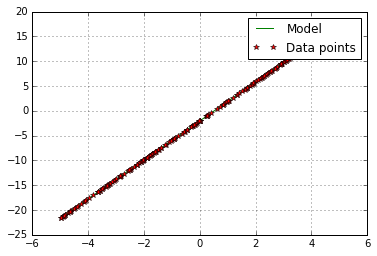

Coefficients are correct


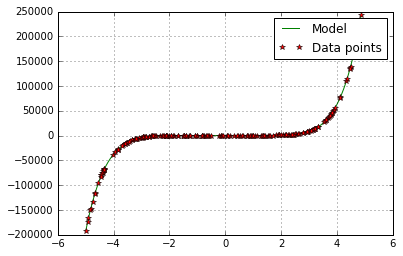

Coefficients are correct


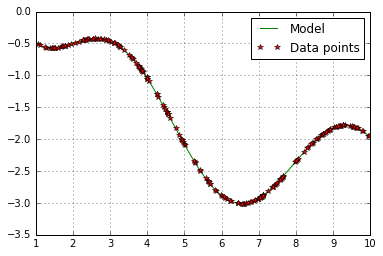

Coefficients are correct


In [4]:
test_linear(-5, 5, 200)
test_polynomial(7, -5, 5, 200)
test_nonlinear([math.sin, math.cos, math.log], 1, 10, 200)


#### Кросс-валидации

Я реализовала два варианта кросс-валидации: Leave One Out и K-fold.

In [5]:
def leave_one_out(x, y, regression, *args):
    cv = 0
    for i in range(len(x)):
        outer_x = x[i]
        outer_y = y[i]
        mask = np.ones(len(x), dtype=bool)
        mask[i] = 0
        new_x = x[mask]
        new_y = y[mask]
        model = regression(new_x, new_y, *args)[0]
        cv += np.linalg.norm(model(outer_x) - outer_y) ** 2
    cv /= len(x)
    return cv


def k_fold(k, x, y, regression, *args):
    cv = 0
    q = int(len(x) / k)
    r = len(x) % k
    nums = []
    for i in range(r):
        nums.append(i * (q + 1))
    for i in range(r, k):
        nums.append(i * q + r)
    nums.append(len(x))
    for i in range(k):
        outer_x = []
        new_x = []
        outer_y = []
        new_y = []
        for j in range(len(x)):
            if j in range(nums[i], nums[i + 1]):
                outer_x.append(x[j])
                outer_y.append(y[j])
            else:
                new_x.append(x[j])
                new_y.append(y[j])
        new_x = np.array(new_x)
        new_y = np.array(new_y)
        outer_x = np.array(outer_x)
        outer_y = np.array(outer_y)
        model = regression(new_x, new_y, *args)[0]
        cv += np.array(
            list(map(lambda pair: np.linalg.norm(model(pair[0]) - pair[1]) ** 2, zip(outer_x, outer_y)))).mean()
    cv /= k
    return cv


#### Датасет 1

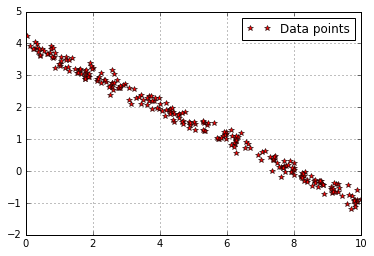

In [6]:
__x__, __y__ = open_pickle("task2_dataset_1.txt")
draw_points(__x__, __y__)

Из графического представления датасета достаточно очевидно, что лучшие результаты должна дать линейная регрессия.

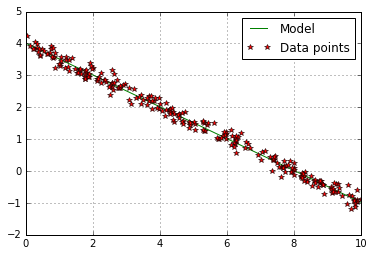

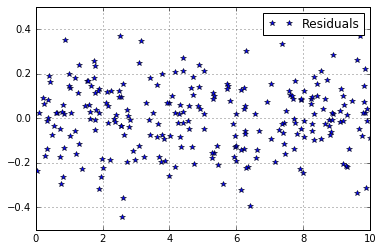

Leave-one-out CV: 0.0233138405295
K-fold CV: 0.0234860659849


In [7]:
__x__, __y__ = open_pickle("task2_dataset_1.txt")
__model__ = linear_regression(__x__, __y__, draw_flag=True)[0]
draw_residuals(__x__, __y__, __model__)
print("Leave-one-out CV:", leave_one_out(__x__, __y__, linear_regression))
print("K-fold CV:", k_fold(10, __x__, __y__, linear_regression))


Попробуем применить полиномиальную регрессию со степенью 5. Результаты кросс-валидации хорошие, но если посмотреть на полученную модель, то можно заметить, что коэффиценты при старших степенях полинома довольно малы. По сути, старшие степени полинома несущественны.

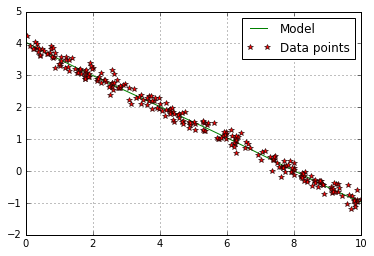

Coefficients: (4.036936357718011, -0.5529121404539797, 0.01713042406759191, -0.00023062516998229032, -0.0003269882364421127, 2.3119185074873226e-05)


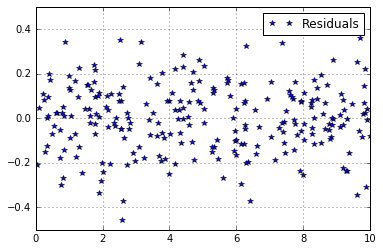

Leave-one-out CV: 0.0238257009278
K-fold CV: 0.0240543056417


In [8]:
__x__, __y__ = open_pickle("task2_dataset_1.txt")
__model__, __coeffs__ = polynomial_regression(__x__, __y__, 5, draw_flag=True)
print("Coefficients: ({})".format(reduce(lambda x, y: "{}, {}".format(x, y), __coeffs__)))
draw_residuals(__x__, __y__, __model__)
print("Leave-one-out CV:", leave_one_out(__x__, __y__, polynomial_regression, *[5]))
print("K-fold CV:", k_fold(10, __x__, __y__, polynomial_regression, *[5]))


Попробуем также использовать нелинейную регрессию с набором функций, включающих в себя тригонометрические полиномы, $f(x) = x$ и константу.

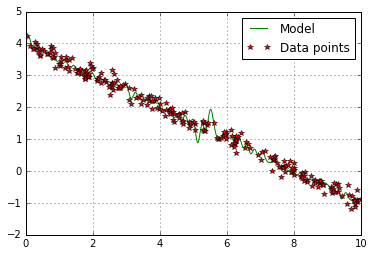

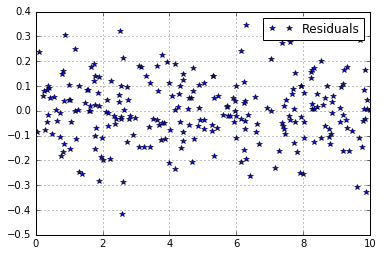

Leave-one-out CV: 0.03465132613
K-fold CV: 0.036449906605


In [9]:
__x__, __y__ = open_pickle("task2_dataset_1.txt")
__funcs__ = trigonometrics(30) + [polynomials(1)[1]]
__model__ = nonlinear_regression(__x__, __y__, __funcs__, draw_flag=True)[0]
draw_residuals(__x__, __y__, __model__)
print("Leave-one-out CV:", leave_one_out(__x__, __y__, nonlinear_regression, __funcs__))
print("K-fold CV:", k_fold(10, __x__, __y__, nonlinear_regression, __funcs__))


Из результатов кросс-валидации видно, что линейная регрессия дала наилучшую модель, но и полиномиальная и нелинейная регрессии проявили себя весьма хорошо.

#### Датасет 2

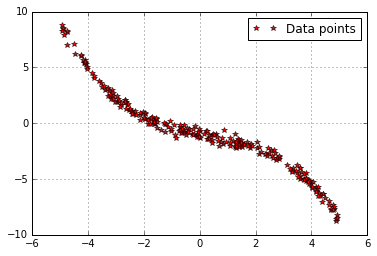

In [10]:
__x__, __y__ = open_pickle("task2_dataset_2.txt")
draw_points(__x__, __y__)

По графическому представлению датасета, напоминающему кубическую параболу,  я предполагаю, что эффективна будет полиномиальная регрессия с полиномом третьей степени.

Однако, попробуем сначала линейную. Очевидно, что остатки регресии зависят от $x$. Кросс-валидация подтверждает, что это далеко не лучшая модель для данного датасета.

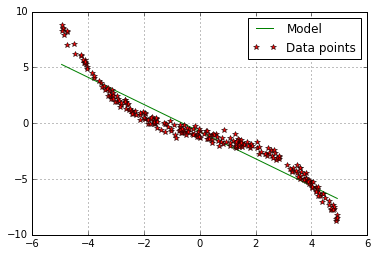

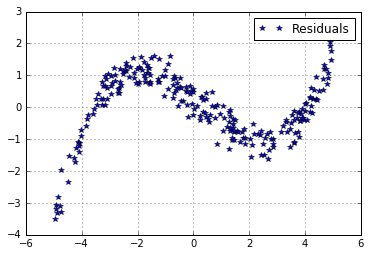

Leave-one-out CV: 1.05290592528
K-fold CV: 1.05728649869


In [11]:
__x__, __y__ = open_pickle("task2_dataset_2.txt")
__model__ = linear_regression(__x__, __y__, draw_flag=True)[0]
draw_residuals(__x__, __y__, __model__)
print("Leave-one-out CV:", leave_one_out(__x__, __y__, linear_regression))
print("K-fold CV:", k_fold(10, __x__, __y__, linear_regression))


Полиномиальная регрессия дает отличные результаты:

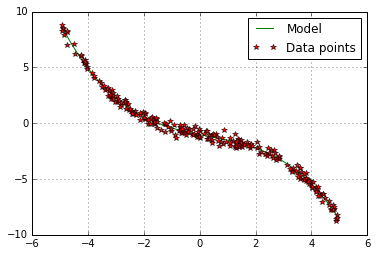

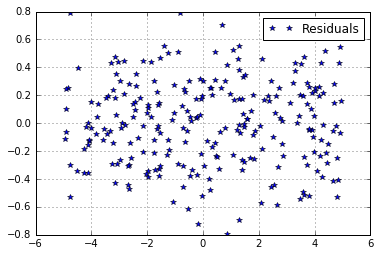

Leave-one-out CV: 0.0934745843477
K-fold CV: 0.093942562268


In [12]:
__x__, __y__ = open_pickle("task2_dataset_2.txt")
__model__ = polynomial_regression(__x__, __y__, 3, draw_flag=True)[0]
draw_residuals(__x__, __y__, __model__)
print("Leave-one-out CV:", leave_one_out(__x__, __y__, polynomial_regression, *[3]))
print("K-fold CV:", k_fold(10, __x__, __y__, polynomial_regression, *[3]))


Применим нелинейную регрессию с теми же функциями, что и для предыдущего датасета. Результаты получаются лучшие, нежели у линейной регрессии:

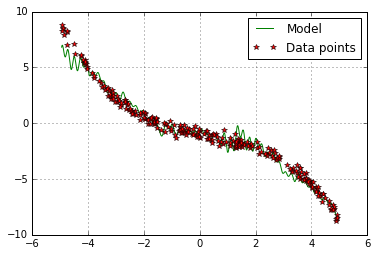

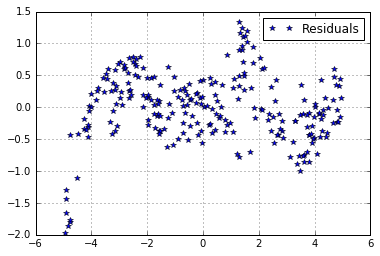

Leave-one-out CV: 0.542644325757
K-fold CV: 0.574632439585


In [13]:
__x__, __y__ = open_pickle("task2_dataset_2.txt")
__funcs__ = trigonometrics(30) + [polynomials(1)[1]]
__model__ = nonlinear_regression(__x__, __y__, __funcs__, draw_flag=True)[0]
draw_residuals(__x__, __y__, __model__)
print("Leave-one-out CV:", leave_one_out(__x__, __y__, nonlinear_regression, __funcs__))
print("K-fold CV:", k_fold(10, __x__, __y__, nonlinear_regression, __funcs__))


Как я и предполагала, наилучшей моделью для данного датасета оказался полином третьей степени.

#### Датасет 3

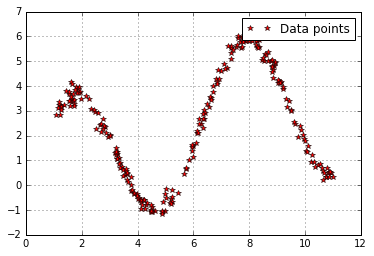

In [14]:
__x__, __y__ = open_pickle("task2_dataset_3.txt")
draw_points(__x__, __y__)

На первый взгляд мне кажется, что хорошую модель дала бы нелинейная регрессия, использующая функцию синуса и линейную добавку.

Применять линейную регрессию к данному датасету довольно бесполезно, как видно из остатков регрессии и результатов кросс-валидации:

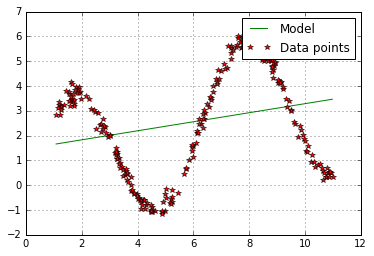

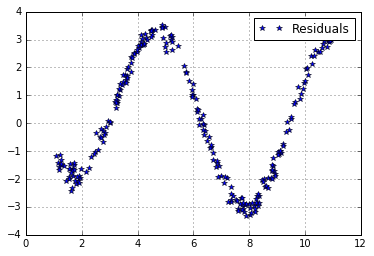

Leave-one-out CV: 4.58407054879
K-fold CV: 4.57501059636


In [15]:
__x__, __y__ = open_pickle("task2_dataset_3.txt")
__model__ = linear_regression(__x__, __y__, draw_flag=True)[0]
draw_residuals(__x__, __y__, __model__)
print("Leave-one-out CV:", leave_one_out(__x__, __y__, linear_regression))
print("K-fold CV:", k_fold(10, __x__, __y__, linear_regression))


Хорошей моделью оказался полином 7 степени:

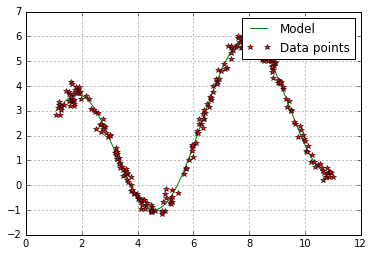

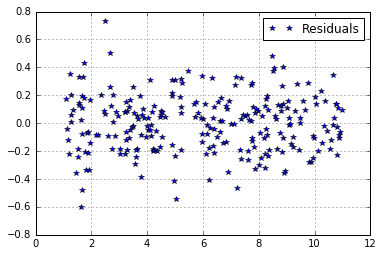

Leave-one-out CV: 0.043456198587
K-fold CV: 0.0427966554805


In [16]:
__x__, __y__ = open_pickle("task2_dataset_3.txt")
__model__ = polynomial_regression(__x__, __y__, 7, draw_flag=True)[0]
draw_residuals(__x__, __y__, __model__)
print("Leave-one-out CV:", leave_one_out(__x__, __y__, polynomial_regression, *[7]))
print("K-fold CV:", k_fold(10, __x__, __y__, polynomial_regression, *[7]))


Проверим предположение, сделанное в начале исследования данного датасета.

Модель дает неплохие результаты, но видно, что остатки регрессии все еще зависят от $x$, скорее всего, квадратично.

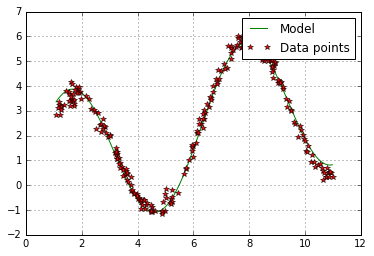

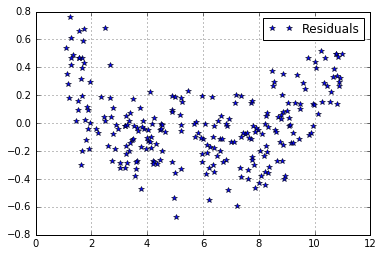

Leave-one-out CV: 0.0734958482569
K-fold CV: 0.0724194646894


In [17]:
__x__, __y__ = open_pickle("task2_dataset_3.txt")
__funcs__ = polynomials(1) + [math.sin]
__model__ = nonlinear_regression(__x__, __y__, __funcs__, draw_flag=True)[0]
draw_residuals(__x__, __y__, __model__)
print("Leave-one-out CV:", leave_one_out(__x__, __y__, nonlinear_regression, __funcs__))
print("K-fold CV:", k_fold(10, __x__, __y__, nonlinear_regression, __funcs__))


Попробуем повысить степень добавочного полинома до второй. Теперь остатки не зависят от аргументов, и кросс-валидация дает лучшие результаты.

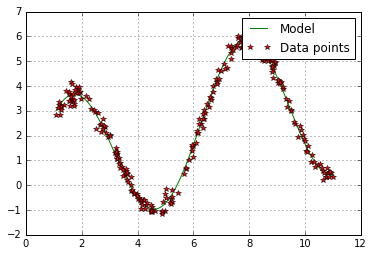

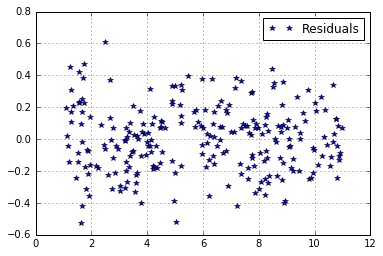

Leave-one-out CV: 0.0433636826723
K-fold CV: 0.0429335285857


In [18]:
__x__, __y__ = open_pickle("task2_dataset_3.txt")
__funcs__ = polynomials(2) + [math.sin]
__model__ = nonlinear_regression(__x__, __y__, __funcs__, draw_flag=True)[0]
draw_residuals(__x__, __y__, __model__)
print("Leave-one-out CV:", leave_one_out(__x__, __y__, nonlinear_regression, __funcs__))
print("K-fold CV:", k_fold(10, __x__, __y__, nonlinear_regression, __funcs__))


Кросс-валидация выделяет две хорошие модели: полином седьмой степени и нелинейную модель с синусом и полиномом второй степени. Вероятно, предпочтительнее было бы использовать вторую, так как в ней меньшее число параметров.

#### Выводы
1. Использование регрессии требует наблюдения человека - выбора функций для регрессии, проверки остатков.
2. Для одного датасета может быть получено несколько приблизительно одинаково хороших моделей.
3. Кросс-валидация позволяет эффективно сравнивать построенные модели.

4. ML - это крайне увлекательно, но спать иногда тоже нужно. :)

In [30]:
from random import random

__x__ = [[random() * 5]for _ in range(100)]
__x__ = np.array(__x__)
__y__ = [[random() * 5]for _ in range(100)]
__y__ = np.array(__y__)

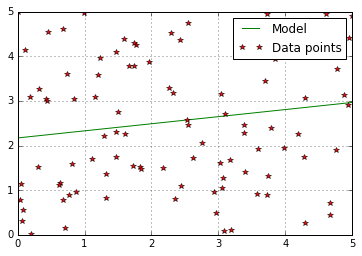

[ 2.16964398  0.1590777 ]


In [31]:
model, coeffs = linear_regression(__x__, __y__, draw_flag=True)
print(coeffs)

In [36]:
def k_fold_cor(k, x, y, regression, *args):
    a = 0
    q = int(len(x) / k)
    for i in range(k):
        outer_x = []
        new_x = []
        outer_y = []
        new_y = []
        for j in range(len(x)):
            if j in range(q*i, q*(i+1)):
                outer_x.append(x[j])
                outer_y.append(y[j])
            else:
                new_x.append(x[j])
                new_y.append(y[j])
        new_x = np.array(new_x)
        new_y = np.array(new_y)
        outer_x = np.array(outer_x)
        outer_y = np.array(outer_y)
        model, coeffs = regression(new_x, new_y, *args)
        a += coeffs[1]
    a /= k
    return a


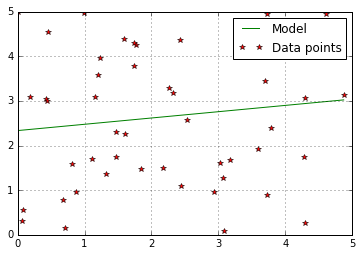

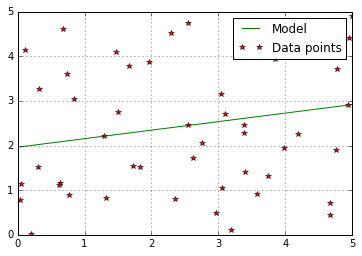

0.16609554473444404

In [38]:
k_fold_cor(2, __x__, __y__, linear_regression, True)

In [42]:
def make_X_matrix(x, funcs):
    result = []
    for x_i in x[:, :]:
        result.append(list(map(lambda f: f(x_i), funcs)))
    return np.matrix(result)

def build_model(coeffs, funcs):
    return lambda x: sum(map(sum(map(lambda a: a[0] * a[1](x), zip(coeffs_, funcs))), coeffs))

def generate_noiseless_dataset(funcs, m, x_min, x_max, n):
    x = np.random.rand(n, m) * (x_max - x_min) + x_min
    print(x)
    coeffs = (np.random.rand(len(funcs), m) * 10 - 5)
    model = build_model(coeffs, funcs)
    y = []
    for x_i in x:
        n = list()
        for x_i_j in x_i:
            n.append(model(float(x_i_j)))
        y.append(n)
    y = np.array(y)
    return x, y, coeffs

generate_noiseless_dataset(polynomials(1), 3, 0, 5, 10)

[[ 1.01756539  1.17987199  0.88450499]
 [ 0.22497056  2.44422213  2.9215185 ]
 [ 3.39604206  4.99572171  0.49852335]
 [ 1.429042    3.82980718  2.02316924]
 [ 1.04047183  0.98223659  4.65746225]
 [ 1.37122573  0.09792928  1.94398026]
 [ 0.60955313  3.34549815  0.64902797]
 [ 1.9126072   2.93018324  2.92551252]
 [ 2.95413489  1.19569741  4.95414065]
 [ 1.47408649  1.38608533  3.33927204]]


In [55]:
def make_X_matrix_multidim_linear(x):
    return (np.matrix(list(map(lambda x_i: [1]+list(x_i), x))))

def build_model_multidim_linear(coeffs):
    return lambda x: sum(map(lambda p: p[0] * p[1], zip(coeffs, [1]+list(x))))

def linear_regression_multidim(x, y):
    X = make_X_matrix_multidim_linear(x)
    coeffs = evaluate_coeffs(X, y)
    model = build_model_multidim_linear(coeffs)
    return model, coeffs

__x__ = np.random.rand(100, 10) * 10
__y__ = np.random.rand(100, 1) * 10

m, c = linear_regression_multidim(__x__, __y__)
print(c)

[ 3.83809669 -0.10654309  0.01218631  0.24192708  0.07905775 -0.06959951
  0.01851864  0.03862737 -0.04266714  0.06054119  0.15873875]
